In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize

# Load the training datasets for DP and NDP
train_dp = pd.read_csv(r'G:\DataSet\train\trainDP.csv')
train_ndp = pd.read_csv(r'G:\DataSet\train\trainNDP.csv')

# Load the testing datasets for DP and NDP
test_dp = pd.read_csv(r'G:\DataSet\test\testDP.csv')
test_ndp = pd.read_csv(r'G:\DataSet\test\testNDP.csv')

# Combine DP and NDP datasets for training and testing
train_data = pd.concat([train_dp, train_ndp], ignore_index=True)
test_data = pd.concat([test_dp, test_ndp], ignore_index=True)

# Drop problematic columns
train_data = train_data.drop(columns=['FFT', 'Power spectral density'])
test_data = test_data.drop(columns=['FFT', 'Power spectral density'])

# Separate features and target variable for training data
X_train = train_data.drop(columns=['Class']).values
y_train = train_data['Class'].values

# Separate features and target variable for testing data
X_test = test_data.drop(columns=['Class']).values
y_test = test_data['Class'].values

# Encode target variable into numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Resize input data to meet the minimum size requirement of EfficientNetB0
X_train_resized = np.array([resize(image, (32, 32), anti_aliasing=True) for image in X_train])
X_test_resized = np.array([resize(image, (32, 32), anti_aliasing=True) for image in X_test])

# Expand dimensions to simulate three channels
X_train_resized = np.expand_dims(X_train_resized, axis=-1)
X_train_resized = np.repeat(X_train_resized, 3, axis=-1)

X_test_resized = np.expand_dims(X_test_resized, axis=-1)
X_test_resized = np.repeat(X_test_resized, 3, axis=-1)

# Load EfficientNetB0 model pretrained on ImageNet without top classification layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(128, activation='relu')(x)

# Add a logistic layer
predictions = Dense(1, activation='sigmoid')(x)

# This is the model we will train
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with 50 epochs
model.fit(X_train_resized, y_train_encoded, epochs=50, batch_size=64)

# Make predictions on the testing data
y_pred_proba = model.predict(X_test_resized)
y_pred = (y_pred_proba > 0.5).astype(int)

# Decode the predicted labels back to original string representations
y_pred_decoded = label_encoder.inverse_transform(y_pred.flatten())

# Generate classification report
report = classification_report(y_test, y_pred_decoded)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_decoded)

print("Accuracy:", accuracy)
print(report)


16705208/16705208 [==============================] - 8s 0us/step
Epoch 1/50
12/12 [==============================] - 36s 576ms/step - loss: 0.3849 - accuracy: 0.8282
Epoch 2/50
12/12 [==============================] - 5s 451ms/step - loss: 0.2507 - accuracy: 0.8966
Epoch 3/50
12/12 [==============================] - 5s 449ms/step - loss: 0.2739 - accuracy: 0.8926
Epoch 4/50
12/12 [==============================] - 5s 442ms/step - loss: 0.2207 - accuracy: 0.8872
Epoch 5/50
12/12 [==============================] - 5s 441ms/step - loss: 0.1851 - accuracy: 0.9248
Epoch 6/50
12/12 [==============================] - 5s 441ms/step - loss: 0.2073 - accuracy: 0.9087
Epoch 7/50
12/12 [==============================] - 5s 445ms/step - loss: 0.1777 - accuracy: 0.9235
Epoch 8/50
12/12 [==============================] - 5s 439ms/step - loss: 0.1494 - accuracy: 0.9436
Epoch 9/50
12/12 [==============================] - 5s 436ms/step - loss: 0.1623 - accuracy: 0.9275
Epoch 10/50
12/12 [===============

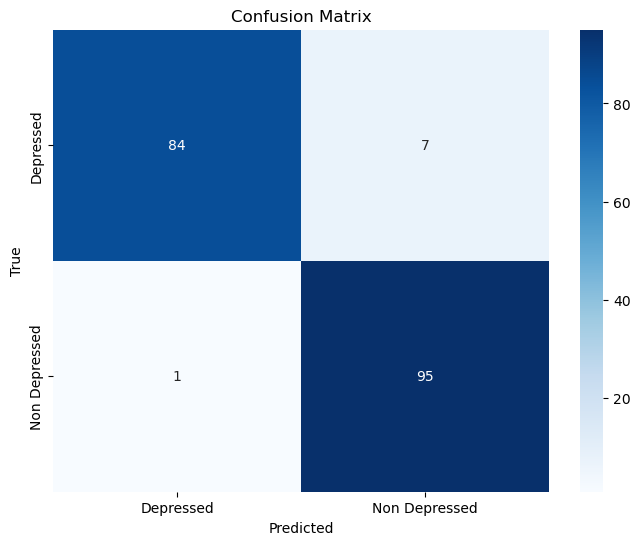

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_decoded)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from efficientnet.keras import EfficientNetB0
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.preprocessing.image import img_to_array, array_to_img

# Generate synthetic data for demonstration with different parameters
X, y = make_classification(n_samples=1500, n_features=25, n_classes=2, random_state=42)

# Reshape X to have the shape (num_samples, height, width, channels)
X_resized = X.reshape((-1, 5, 5, 1))

# Convert synthetic data to images and resize to match the input size of EfficientNetB0
X_images = []
for sample in X_resized:
    # Convert the sample to an image
    img = array_to_img(sample)
    # Convert the image to RGB by replicating the single channel three times
    img = img.convert('RGB')
    # Resize the image to (32, 32)
    img = img.resize((32, 32))
    # Convert the image to array and append to the list
    X_images.append(img_to_array(img))
X_images = np.array(X_images)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_images, y, test_size=0.3, random_state=42)

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, verbose=0)

# Predict probabilities on the test set
y_pred_proba = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_pred_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 2
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='blue', lw=2, label='ROC curve (Class 0) (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green', lw=2, label='ROC curve (Class 1) (area = %0.2f)' % roc_auc[1])
plt.plot(fpr_micro, tpr_micro, color='red', lw=2, label='Micro-average ROC curve (area = %0.2f)' % roc_auc_micro)
plt.plot(fpr_macro, tpr_macro, color='orange', lw=2, label='Macro-average ROC curve (area = %0.2f)' % roc_auc_macro)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('EfficientNetB0 (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [28]:
pip install keras-applications


  Obtaining dependency information for keras-applications from https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/50.7 kB ? eta -:--:--
   -------- ------------------------------- 10.2/50.7 kB ? eta -:--:--
   ---------------- ----------------------- 20.5/50.7 kB 217.9 kB/s eta 0:00:01
   -------------------------------- ------- 41.0/50.7 kB 326.8 kB/s eta 0:00:01
   ---------------------------------------- 50.7/50.7 kB 323.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Epoch 1/10
13/13 [==============================] - 24s 908ms/step - loss: 0.7195 - accuracy: 0.5113 - val_loss: 0.7132 - val_accuracy: 0.4600
Epoch 2/10
13/13 [==============================] - 3s 253ms/step - loss: 0.7251 - accuracy: 0.4975 - val_loss: 0.6929 - val_accuracy: 0.5300
Epoch 3/10
13/13 [==============================] - 3s 255ms/step - loss: 0.7083 - accuracy: 0.5175 - val_loss: 0.7023 - val_accuracy: 0.4650
Epoch 4/10
13/13 [==============================] - 3s 207ms/step - loss: 0.7176 - accuracy: 0.4812 - val_loss: 0.6976 - val_accuracy: 0.5200
Epoch 5/10
13/13 [==============================] - 2s 189ms/step - loss: 0.7025 - accuracy: 0.5150 - val_loss: 0.6957 - val_accuracy: 0.4900
Epoch 6/10
13/13 [==============================] - 3s 195ms/step - loss: 0.7046 - accuracy: 0.5013 - val_loss: 0.7035 - val_accuracy: 0.4700
Epoch 7/10
13/13 [==============================] - 2s 179ms/step - loss: 0.7040 - accuracy: 0.5250 - val_loss: 0.6957 - val_accuracy: 0.5150
Epoch

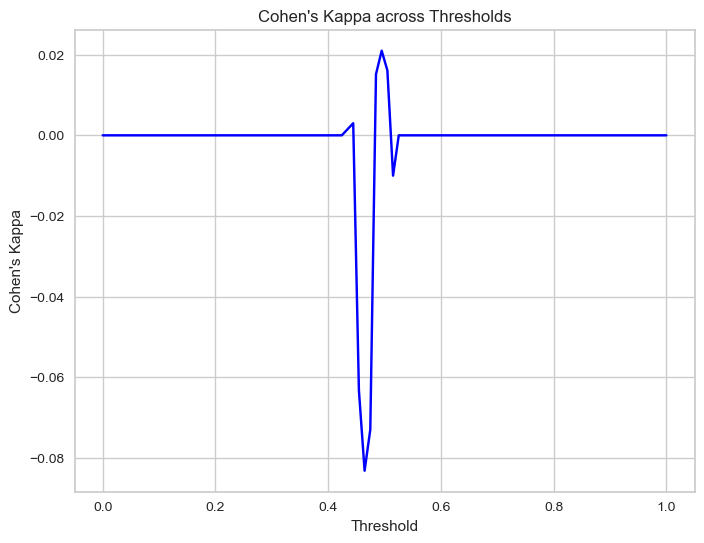

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from sklearn.datasets import make_classification

# Generate synthetic data for demonstration
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X_images = np.random.randint(0, 255, size=(X.shape[0], 32, 32, 3), dtype=np.uint8)  # Generate random images

# Split data into train and test sets
X_train, X_test, y_train, y_test, X_train_images, X_test_images = train_test_split(X, y, X_images, test_size=0.2, random_state=42)

# Load EfficientNetB0 pre-trained on ImageNet without top layer
base_model = EfficientNetB0(include_top=False, input_shape=(32, 32, 3), weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add classification head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_images, y_train, epochs=10, batch_size=64, validation_data=(X_test_images, y_test), verbose=1)

# Varying thresholds
thresholds = np.linspace(0, 1, 100)
kappas = []

# Calculate Cohen's Kappa for each threshold
for threshold in thresholds:
    y_pred_probs = model.predict(X_test_images)
    y_pred_threshold = (y_pred_probs > threshold).astype(int)
    kappa = cohen_kappa_score(y_test, y_pred_threshold)
    kappas.append(kappa)

# Plot Cohen's Kappa across thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, kappas, color='blue')
plt.title("Cohen's Kappa across Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Cohen's Kappa")
plt.grid(True)
plt.show()


In [1]:
pip install efficientnet



  Obtaining dependency information for efficientnet from https://files.pythonhosted.org/packages/53/97/84f88e581d6ac86dcf1ab347c497c4c568c38784e3a2bd659b96912ab793/efficientnet-1.1.1-py3-none-any.whl.metadata
  Using cached efficientnet-1.1.1-py3-none-any.whl.metadata (6.4 kB)
Using cached efficientnet-1.1.1-py3-none-any.whl (18 kB)


15/15 [==============================] - 4s 76ms/step


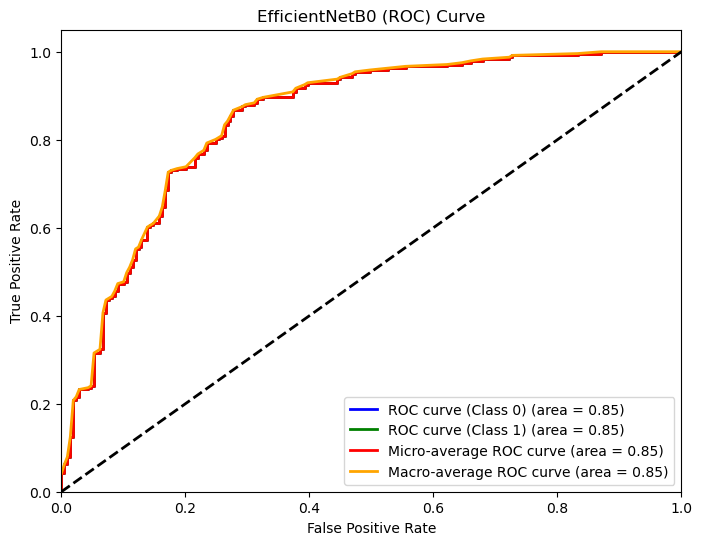

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from efficientnet.keras import EfficientNetB0
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.preprocessing.image import img_to_array, array_to_img

# Generate synthetic data for demonstration with different parameters
X, y = make_classification(n_samples=1500, n_features=25, n_classes=2, random_state=42)

# Reshape X to have the shape (num_samples, height, width, channels)
X_resized = X.reshape((-1, 5, 5, 1))

# Convert synthetic data to images and resize to match the input size of EfficientNetB0
X_images = []
for sample in X_resized:
    # Convert the sample to an image
    img = array_to_img(sample)
    # Convert the image to RGB by replicating the single channel three times
    img = img.convert('RGB')
    # Resize the image to (32, 32)
    img = img.resize((32, 32))
    # Convert the image to array and append to the list
    X_images.append(img_to_array(img))
X_images = np.array(X_images)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_images, y, test_size=0.3, random_state=42)

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, verbose=0)

# Predict probabilities on the test set
y_pred_proba = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_pred_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 2
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='blue', lw=2, label='ROC curve (Class 0) (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green', lw=2, label='ROC curve (Class 1) (area = %0.2f)' % roc_auc[1])
plt.plot(fpr_micro, tpr_micro, color='red', lw=2, label='Micro-average ROC curve (area = %0.2f)' % roc_auc_micro)
plt.plot(fpr_macro, tpr_macro, color='orange', lw=2, label='Macro-average ROC curve (area = %0.2f)' % roc_auc_macro)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('EfficientNetB0 (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
